In [2]:
# Importo le librerie necessarie

from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [3]:
# 1. Caricamento dati CIFAR-10
# carico il dataset che ha 50000 immagini per il training e 10000 per il test (ogni immagine è di 32x32 pixel a colori, 3 canali RGB)
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# 2. Appiattisci le etichette
# trasformo le etichette da matrice a un vettore monodimensionale
# le etichette di training prima avevano la forma (50000,1) e sono state trasformate in (50000,))
y_train = y_train.flatten()
y_test = y_test.flatten()

# 3. Sottocampionamento casuale stratificato
# Riduco il dataset manetendo la distribuzione delle classi (stratify=y_train) e ottendo sempre la stessa suddivisione dei dati (random_state=42)
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train, y_train,
    train_size=0.2, stratify=y_train, random_state=42
)

X_test_sub, _, y_test_sub, _ = train_test_split(
    X_test, y_test,
    train_size=0.2, stratify=y_test, random_state=42
)

# 4. Flatten delle immagini da 32x32x3 a 3072
# Ogni immagine originare ha dimensione 32x32x3=3072 pixel totali
# Appiattisco in un vettore 1D di lunghezza 3072 per poter usare modelli (es. SVM, regressione logistica) che non accettano input 3D
X_train_sub = X_train_sub.reshape((X_train_sub.shape[0], -1))
X_test_sub = X_test_sub.reshape((X_test_sub.shape[0], -1))

# 5. Stampa forme finali
print("x_train_sub:", X_train_sub.shape)
print("y_train_sub:", y_train_sub.shape)
print("x_test_sub:", X_test_sub.shape)
print("y_test_sub:", y_test_sub.shape)

# 6. Standardizzo i dati
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sub)
X_test_scaled = scaler.transform(X_test_sub)

# 7. Applico PCA per ridurre la dimensionalità
pca = PCA(n_components=0.90, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 8. Stampa le nuove forme dopo PCA
print("x_train_pca:", X_train_pca.shape)
print("x_test_pca:", X_test_pca.shape)

x_train_sub: (10000, 3072)
y_train_sub: (10000,)
x_test_sub: (2000, 3072)
y_test_sub: (2000,)
x_train_pca: (10000, 100)
x_test_pca: (2000, 100)


==> Allenamento e ricerca parametri per LogisticRegression
Migliori parametri: {'C': 0.01, 'max_iter': 300, 'solver': 'liblinear'}
Accuracy media CV: 0.3794
------------------------------------------------------------
==> Allenamento e ricerca parametri per SVM
Migliori parametri: {'C': 1.0, 'kernel': 'rbf'}
Accuracy media CV: 0.4608
------------------------------------------------------------
==> Allenamento e ricerca parametri per KNN
Migliori parametri: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy media CV: 0.3415
------------------------------------------------------------
==> Allenamento e ricerca parametri per DecisionTree
Migliori parametri: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 5}
Accuracy media CV: 0.2729
------------------------------------------------------------

=== Valutazione test per LogisticRegression ===


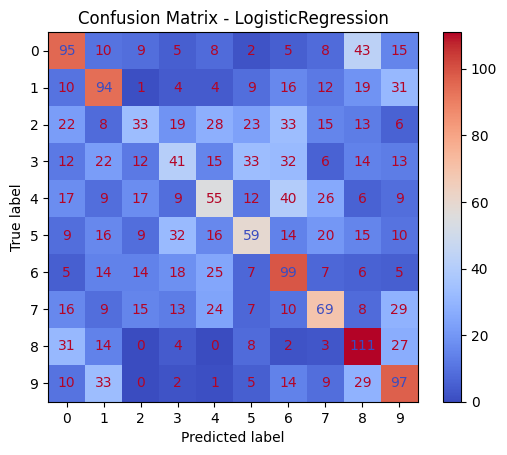

Precision: 0.3667
Recall:    0.3765
F1 Score:  0.3659
Accuracy:  0.3765
------------------------------------------------------------

=== Valutazione test per SVM ===


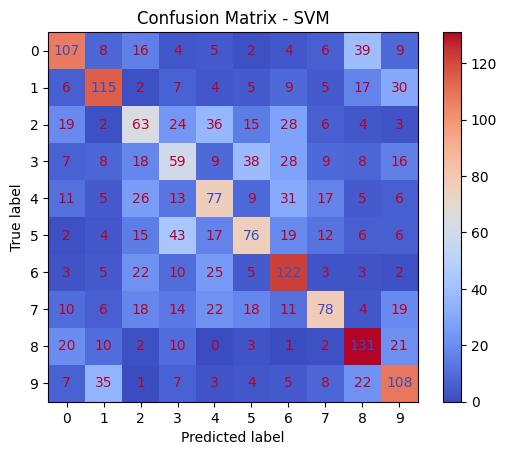

Precision: 0.4661
Recall:    0.4680
F1 Score:  0.4642
Accuracy:  0.4680
------------------------------------------------------------

=== Valutazione test per KNN ===


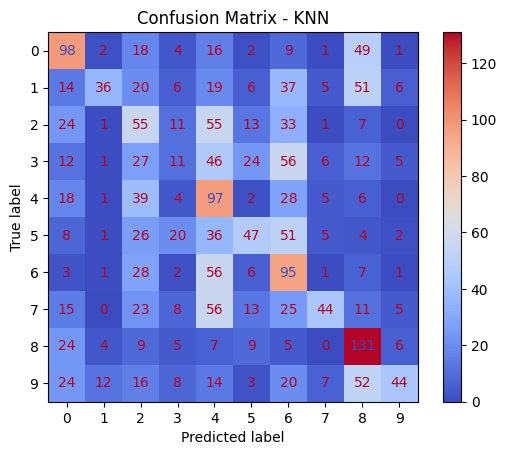

Precision: 0.3863
Recall:    0.3290
F1 Score:  0.3133
Accuracy:  0.3290
------------------------------------------------------------

=== Valutazione test per DecisionTree ===


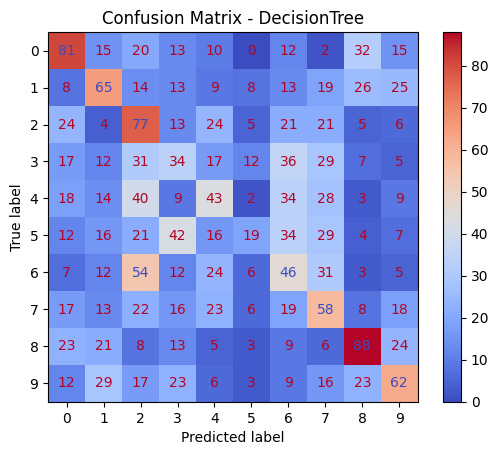

Precision: 0.2902
Recall:    0.2865
F1 Score:  0.2811
Accuracy:  0.2865
------------------------------------------------------------


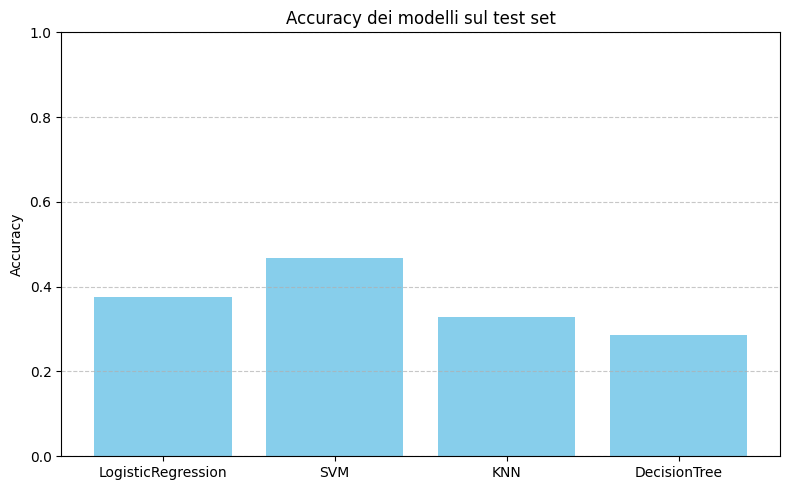


Modello selezionato: SVM
Accuracy finale sul test set: 0.4680


In [5]:

# 1. Definizione dei modelli da confrontare
models = {
    'LogisticRegression': LogisticRegression(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier()
}

# 2. Griglie di iperparametri per la ricerca
param_grids = {
    'LogisticRegression': {
        'max_iter': [300, 500],
        'C': [0.01, 0.1, 1.0],
        'solver': ['liblinear', 'lbfgs']
    },
    'SVM': {
        'C': [0.01, 0.1, 1.0],
        'kernel': ['linear', 'poly', 'rbf']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'DecisionTree': {
        'max_depth': [3, 4, 5, 6, 7, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['entropy', 'gini']
    }
}

# 3. Dizionari per salvare i risultati
best_models = {}
best_scores = {}
best_params = {}

# 4. GridSearchCV per ogni modello
for name in models:
    print(f"==> Allenamento e ricerca parametri per {name}")

    model = models[name]
    param_grid = param_grids[name]

    grid = GridSearchCV(
        model, param_grid,
        cv=5, scoring='accuracy', n_jobs=-1
    )
    grid.fit(X_train_pca, y_train_sub)  # Usa X_train_pca

    best_models[name] = grid.best_estimator_
    best_scores[name] = grid.best_score_
    best_params[name] = grid.best_params_

    print(f"Migliori parametri: {grid.best_params_}")
    print(f"Accuracy media CV: {grid.best_score_:.4f}")
    print("-" * 60)

# 5. Selezione del miglior modello
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]

# 6. Valutazione del modello migliore sul test set
test_pred = best_model.predict(X_test_pca)
test_final_accuracy = accuracy_score(y_test_sub, test_pred)

# 7. Valutazione di tutti i modelli sul test set
accuracies = {}

for model_name, model in best_models.items():
    print(f"\n=== Valutazione test per {model_name} ===")

    predizioni = model.predict(X_test_pca)

    cm = confusion_matrix(y_test_sub, predizioni)
    ConfusionMatrixDisplay(cm).plot(cmap="coolwarm")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    precision = precision_score(y_test_sub, predizioni, average='weighted')
    recall = recall_score(y_test_sub, predizioni, average='weighted')
    f1 = f1_score(y_test_sub, predizioni, average='weighted')
    accuracy = accuracy_score(y_test_sub, predizioni)

    accuracies[model_name] = accuracy

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Accuracy:  {accuracy:.4f}")
    print("-" * 60)

# 8. Grafico: confronto tra le accuracy dei modelli
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.title('Accuracy dei modelli sul test set')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 9. Stampa finale
print("\nModello selezionato:", best_model_name)
print(f"Accuracy finale sul test set: {test_final_accuracy:.4f}")